### 메타 필터링 통해서 api 주제 필터링하여 벡터 db 검색 + 질문 의도 분류 및 멀티모달 적용된 langgraph

- 메타 필터링 외에 rag 자체에서 변경된 사항은 질문 의도 분류 및 멀티모달인데, 질문 의도 분류 및 멀티모달은 rag 평가에 사용하지 않기 때문에 메타 필터링만 달라진 것으로 체크함

In [1]:
from pathlib import Path
import sys

root = Path.cwd()
while not (root / "utils_3").exists() and root != root.parent:
    root = root.parent
sys.path.insert(0, str(root))

from utils_3.main3 import run_langraph

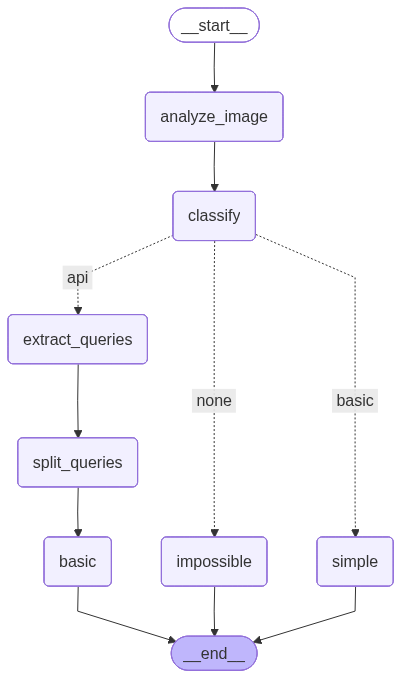

In [2]:
from utils_3.langgraph_setting2 import graph_setting

graph = graph_setting()

graph

## None 은 이미지 url 없기 때문에 설정한 것

In [3]:
response = run_langraph('people api 알려줘', '1', None)
print(response)

run_langraph 호출 - 입력: people api 알려줘, 이미지: False
analyze_image 호출됨 - 이미지 존재: False
생성된 질문 리스트 ['People API에 대해 알려주세요.']
People API에 대해 알려주세요. 검색중...
사용자 통합 질문: people api 알려줘
그래프 실행 결과: {'question': 'people api 알려줘', 'answer': 'People API에 대해 알고 싶으시군요. People API는 Google의 API로, 사용자의 프로필 정보를 읽고 관리할 수 있는 기능을 제공합니다. People API를 사용하기 위해서는 [People API 사용 준비하기](https://developers.google.com/people/v1/getting-started?hl=ko) 문서의 단계를 완료해야 합니다. 이 단계를 완료하면 프로필의 데이터를 읽을 준비가 됩니다.\n\n또한, People API의 공식 문서 URL은 [https://developers.google.com/people?hl=ko](https://developers.google.com/people?hl=ko)입니다. 이곳에서 더 많은 정보를 확인하실 수 있습니다.\n\n추가로, People API에 대한 지원은 [여기](https://developers.google.com/people/support?hl=ko)에서 받을 수 있습니다. 도움이 필요하시면 이 링크를 참고하세요.', 'rewritten': [{'role': 'user', 'content': 'people api 알려줘'}], 'queries': ['People API에 대해 알려주세요.'], 'search_results': [[Document(id='49b18231-4a41-4b74-841d-b6a35e81a757', metadata={'source_file': 'people_v1_profiles.txt', 'tags': 'people', 'last_verified'

In [ ]:
## 환경설정
!pip install -qU ragas langchain langchain-community langchain-openai langchain-chroma langchain-text-splitters pypdf rapidfuzz langgraph gdown chromadb langchain-huggingface sentence-transformers -q

In [8]:
import os
from dotenv import load_dotenv

load_dotenv()
# 필요한 라이브러리 임포트
import os
import pandas as pd
from pprint import pprint
# LangChain 관련 라이브러리
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
# RAGAS 관련 라이브러리
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.testset.persona import Persona
from ragas.testset import TestsetGenerator
from ragas import EvaluationDataset, evaluate
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness

In [5]:
# 벡터 DB 다운로드 실행 (없으면 retriever.py에서 감지하고 자동 다운로드 함)

from pathlib import Path
import sys

# utils_1까지의 루트 잡기
root = Path.cwd()
while not (root / "utils_2").exists() and root != root.parent:
    root = root.parent
sys.path.insert(0, str(root))

# utils_1 안의 chroma_db 폴더 경로
DB_PATH = root / "utils_2" / "chroma_db"

from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma

# 임베딩 모델 초기화 // HuggingFaceEmbeddings
embedding_model = HuggingFaceEmbeddings(
    model_name="BAAI/bge-m3",
    encode_kwargs={"normalize_embeddings": True},
)

vector_store = Chroma(
    embedding_function=embedding_model,
    collection_name="qna_collection",
    persist_directory=str(DB_PATH),
)

print(f"벡터 DB 로드 완료. 저장된 Document 개수: {len(vector_store.get()['ids'])}")

벡터 DB 로드 완료. 저장된 Document 개수: 14858


In [6]:
# 벡터 DB 내용 확인
db_contents = vector_store.get(
    include=['metadatas', 'documents']
)

print("### 벡터 DB의 첫 3개 문서 내용 ###")
for i in range(3):
    print("--- 문서", i + 1, "---")
    print("내용:", db_contents['documents'][i])
    print("메타데이터:", db_contents['metadatas'][i])
    print("-" * 20)

### 벡터 DB의 첫 3개 문서 내용 ###
--- 문서 1 ---
내용: Q: BigQuery에서 새로운 데이터셋을 생성하는 방법은 무엇인가요?
A: 새로운 데이터셋을 생성하려면 다음의 API 메서드를 사용합니다: `insert` 메서드. 요청은 다음과 같이 구성됩니다:

```
POST /bigquery/v2/projects/{projectId}/datasets
```
여기서 `{projectId}`는 데이터셋을 생성할 프로젝트의 ID입니다.
메타데이터: {'source_file': 'bigquery_docs_reference_rest.txt', 'source': '["https://cloud.google.com/bigquery/docs/reference/rest"]', 'tags': 'bigquery', 'last_verified': '2025-08-19'}
--------------------
--- 문서 2 ---
내용: Q: 특정 데이터셋의 정보를 가져오는 방법은 무엇인가요?
A: 특정 데이터셋의 정보를 가져오려면 `get` 메서드를 사용합니다. 요청은 다음과 같이 구성됩니다:

```
GET /bigquery/v2/projects/{projectId}/datasets/{datasetId}
```
여기서 `{projectId}`는 프로젝트의 ID이고, `{datasetId}`는 가져오려는 데이터셋의 ID입니다.
메타데이터: {'source_file': 'bigquery_docs_reference_rest.txt', 'tags': 'bigquery', 'source': '["https://cloud.google.com/bigquery/docs/reference/rest"]', 'last_verified': '2025-08-19'}
--------------------
--- 문서 3 ---
내용: Q: BigQuery에서 데이터셋을 삭제하는 방법은 무엇인가요?
A: 데이터셋을 삭제하려면 `delete` 메서드를 사용합니다. 요청은 다음과 같이 구성됩

## 이미 만들어진 데이터셋 사용 시 스킵

In [10]:
### 합성 데이터셋 생성

from ragas.testset.persona import Persona

# 페르소나 정의
personas = [
    Persona(
        name="expert",
        role_description="최신 구글 API에 대해 박식한 전문가. 한국어 사용자",
    ),
    Persona(
        name="beginner",
        role_description="구글 API에 대해 잘 모르는 일반 사용자. 한국어 사용자",
    ),
]
# LLM과 임베딩 모델 초기화
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1"))
generator_embeddings = HuggingFaceEmbeddings(
    model_name="BAAI/bge-m3",
    encode_kwargs={"normalize_embeddings": True},
)
# TestsetGenerator 생성
generator = TestsetGenerator(
    llm=generator_llm,
    embedding_model=generator_embeddings,
    persona_list=personas
)
# 데이터셋 생성
from ragas.testset.synthesizers.single_hop.specific import (
    SingleHopSpecificQuerySynthesizer,  # 특정 정보에 대한 직접적인 질의를 생성하는 합성기
)

distribution = [
    (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 1.0),
]

for query, _ in distribution:
    prompts = await query.adapt_prompts("korean", llm=generator_llm)  # 프롬프트 언어 설정(한국어)
    query.set_prompts(**prompts)
from ragas.testset.transforms.extractors.llm_based import NERExtractor
from ragas.testset.transforms.splitters import HeadlineSplitter

# HeadlineSplitter(),
transforms = [NERExtractor()]
import random
from langchain_core.documents import Document

all_documents = vector_store.get(include=['documents', 'metadatas'])

# LangChain Document 객체 리스트로 변환
docs = [
    Document(page_content=doc_content, metadata=doc_metadata)
    for doc_content, doc_metadata in zip(all_documents['documents'], all_documents['metadatas'])
]

random.shuffle(docs)
sampled_docs = docs[:30]
# 30개의 합성 데이터셋 생성
dataset = generator.generate_with_langchain_docs(
    documents=sampled_docs,
    testset_size=20,
    transforms=transforms,
    query_distribution=distribution,
)

print("합성 데이터셋 생성 완료")
# 데이터셋을 DataFrame으로 변환
import pandas as pd

pd.set_option('display.max_colwidth', None)

dataset_df = dataset.to_pandas()
display(dataset_df)

# single_hop_specific_query_synthesizer: RAGAS 라이브러리에 내장된 **'질의 합성기(query synthesizer)'**의 한 종류
# 역할: 주어진 문서(컨텍스트)에서 하나의 문서(청크)만으로 답변할 수 있는 구체적인 질문을 자동으로 생성하는 역할
# CSV 파일로 저장

dataset_df.to_csv('./ragas_dataset.csv', index=False)


Applying NERExtractor:   0%|          | 0/30 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/20 [00:00<?, ?it/s]

합성 데이터셋 생성 완료


,user_input,reference_contexts,reference,synthesizer_name
0,CSV 파일을 이용해서 S/MIME 인증서를 관리하려면 어떤 작업이 필요한가요?,"[Q: S/MIME 인증서를 관리하기 위해 CSV 파일을 처리하는 함수에서 어떤 작업을 수행해야 하나요?\nA: S/MIME 인증서를 관리하기 위해 CSV 파일을 처리하는 함수에서는 사용자의 인증서를 나열하고, 기본 인증서가 만료되었거나 설정되지 않은 경우 지정된 파일에서 인증서를 업로드해야 합니다. 그런 다음 만료일이 가장 늦은 인증서를 기본값으로 설정하는 작업을 수행해야 합니다.]","CSV 파일을 처리하는 함수에서는 사용자의 인증서를 나열하고, 기본 인증서가 만료되었거나 설정되지 않은 경우 지정된 파일에서 인증서를 업로드해야 합니다. 그리고 만료일이 가장 늦은 인증서를 기본값으로 설정하는 작업을 해야 합니다.",single_hop_specific_query_synthesizer
1,클라우드 파이어스토어 부하 분산기 어떻게 써야되나요?,[Q: Cloud Firestore의 부하 분산 기능은 어떻게 작동하나요?\nA: Cloud Firestore는 데이터베이스에 대한 트래픽을 지원하기 위해 자동으로 확장되므로 부하 분산기를 실행할 필요가 없습니다.],Cloud Firestore는 데이터베이스에 대한 트래픽을 지원하기 위해 자동으로 확장되므로 부하 분산기를 실행할 필요가 없습니다.,single_hop_specific_query_synthesizer
2,범위 많으면 동의 어렵나요?,[Q: OAuth 2.0을 사용할 때 요청하는 범위의 수가 사용자 동의에 미치는 영향은 무엇인가요?\nA: 범위를 사용 설정하면 애플리케이션은 필요한 리소스에 대한 액세스만 요청하고 사용자는 애플리케이션에 부여하는 액세스 양을 제어할 수 있습니다. 따라서 요청된 범위 수와 사용자 동의를 얻을 가능성 간에 역관계가 있을 수 있습니다. OAuth 2.0 승인을 구현하기 전에 앱에서 액세스 권한이 필요한 범위를 지정하는 것이 좋습니다.],요청된 범위 수가 많으면 사용자 동의를 얻을 가능성이 낮아질 수 있습니다.,single_hop_specific_query_synthesizer
3,"As a beginner who is not familiar with Google APIs, could you please explain in detail how the Cloud Platform is affected when Google Cloud session control features are enabled, and what specific user actions or applications are impacted by these policies?","[Q: Google Cloud 세션 제어 기능이란 무엇이며, 어떤 영향을 미치나요?\nA: GCP 조직의 관리자는 Google Cloud 세션 제어 기능을 사용하여 사용자가 GCP 리소스에 액세스하는 동안 사용자의 재인증을 자주 요구할 수 있습니다. 이 정책은 Google Cloud Console, Google Cloud SDK (gcloud CLI라고도 함), Cloud Platform 범위가 필요한 서드 파티 OAuth 애플리케이션에 대한 액세스에 영향을 미칩니다.]","When Google Cloud session control features are enabled, administrators in a GCP organization can require users to re-authenticate more frequently while accessing GCP resources. This policy affects access to the Google Cloud Console, the Google Cloud SDK (also known as gcloud CLI), and third-party OAuth applications that require Cloud Platform scopes.",single_hop_specific_query_synthesizer
4,"firebase_functions 어떻게 쓰는지 잘 모르겠는데, Cloud Firestore에서 문서 바뀔 때마다 자동으로 뭔가 실행되게 하려면 firebase_functions에서 뭘 써야 되고, 예시 코드도 보여줄 수 있나요?","[Q: Cloud Firestore에서 특정 문서의 모든 변경에 대해 이벤트를 트리거하려면 어떤 함수를 사용해야 하나요?\nA: 특정 문서의 모든 변경에 이벤트를 트리거하려면 `onDocumentWritten` 함수를 사용해야 합니다. 예시는 다음과 같습니다.\n\n```python\nfrom firebase_functions.firestore_fn import (\n on_document_written,\n Event,\n Change,\n DocumentSnapshot,\n)\n\n@on_document_written(document=""users/marie"")\ndef myfunction(event: Event[Change[DocumentSnapshot]]) -> None:\n # Get an object with the current document values.\n # If the document does not exist, it was deleted.\n document = (event.data.after.to_dict()\n if event.data.after is not None else None)\n\n # Get an object with the previous document values.\n # If the document does not exist, it was newly created.\n previous_values = (event.data.before.to_dict()\n if event.data.before is not None else None)\n\n # Perform more operations ...\n```]","Cloud Firestore에서 특정 문서의 모든 변경에 이벤트를 트리거하려면 onDocumentWritten 함수를 사용해야 합니다. 예시는 다음과 같습니다.\n\nfrom firebase_functions.firestore_fn import (\n on_document_written,\n Event,\n Change,\n DocumentSnapshot,\n)\n\n@on_document_written(document=""users/marie"")\ndef myfunction(event: Event[Change[DocumentSnapshot]]) -> None:\n # Get an object with the current document values.\n # If the document does not exist, it was deleted.\n document = (event.data.after.to_dict()\n if event.data.after is not None else None)\n\n # Get an object with the previous document values.\n # If the document does not exist, it was newly created.\n previous_values = (event.data.before.to_dict()\n if event.data.before is not None else None)\n\n # Perform more operations ...",single_hop_specific_query_synthesizer
5,"Firebase에서 다단계 인증(MFA)을 사용할 때 Objective-C로 사용자 인증을 완료하는 방법과 관련된 코드 예시가 궁금합니다. 어떤 방식으로 인증 정보를 가져오고, Objective-C에서는 어떻게 구현하나요?","[Q: 다단계 인증(MFA) 사용 시 Firebase에서 사용자 인증을 완료하는 방법은 무엇인가요?\nA: 다단계 인증(MFA) 사용 시 Firebase에서 사용자 인증을 완료

## 이미 생성된 합성 데이터셋 생성

In [5]:
import pandas as pd

# 같은 폴더(현재 작업 디렉토리)에 저장했다면
dataset_df = pd.read_csv("./ragas_dataset.csv")
print(dataset_df.shape)
display(dataset_df)

(20, 4)


,user_input,reference_contexts,reference,synthesizer_name
0,CSV 파일을 이용해서 S/MIME 인증서를 관리하려면 어떤 작업이 필요한가요?,['Q: S/MIME 인증서를 관리하기 위해 CSV 파일을 처리하는 함수에서 어떤 ...,"CSV 파일을 처리하는 함수에서는 사용자의 인증서를 나열하고, 기본 인증서가 만료되...",single_hop_specific_query_synthesizer
1,클라우드 파이어스토어 부하 분산기 어떻게 써야되나요?,['Q: Cloud Firestore의 부하 분산 기능은 어떻게 작동하나요?\nA:...,Cloud Firestore는 데이터베이스에 대한 트래픽을 지원하기 위해 자동으로 ...,single_hop_specific_query_synthesizer
2,범위 많으면 동의 어렵나요?,['Q: OAuth 2.0을 사용할 때 요청하는 범위의 수가 사용자 동의에 미치는 ...,요청된 범위 수가 많으면 사용자 동의를 얻을 가능성이 낮아질 수 있습니다.,single_hop_specific_query_synthesizer
3,As a beginner who is not familiar with Google ...,"['Q: Google Cloud 세션 제어 기능이란 무엇이며, 어떤 영향을 미치나요...",When Google Cloud session control features are...,single_hop_specific_query_synthesizer
4,"firebase_functions 어떻게 쓰는지 잘 모르겠는데, Cloud Fire...",['Q: Cloud Firestore에서 특정 문서의 모든 변경에 대해 이벤트를 트...,Cloud Firestore에서 특정 문서의 모든 변경에 이벤트를 트리거하려면 on...,single_hop_specific_query_synthesizer
5,Firebase에서 다단계 인증(MFA)을 사용할 때 Objective-C로 사용자...,['Q: 다단계 인증(MFA) 사용 시 Firebase에서 사용자 인증을 완료하는 ...,다단계 인증(MFA) 사용 시 Firebase에서 사용자 인증을 완료하는 방법은 F...,single_hop_specific_query_synthesizer
6,Java를 사용해서 Firestore에 문서를 추가할 때 어떤 코드를 사용하나요?,['Q: Firestore에서 문서에 데이터를 추가할 때 사용하는 Java 코드 예...,다음은 Java에서 Firestore에 문서를 추가할 때 사용하는 코드 예시입니다....,single_hop_specific_query_synthesizer
7,COLUMNS가 Dimension API에서 무슨 뜻인가요?,['Q: Dimension API에서 사용할 수 있는 열거형 값은 무엇인가요?\nA...,COLUMNS는 Dimension API에서 시트의 열에서 작동함을 의미합니다.,single_hop_specific_query_synthesizer
8,ttll이 뭐에요? 그리고 한도 같은거 있나요?,['Q: TTL 정책을 적용할 때 한도 및 제약조건은 무엇인가요?\nA: 컬렉션 그...,"컬렉션 그룹당 하나의 필드만 TTL 필드로 표시할 수 있고, 필드 수준 구성은 최대...",single_hop_specific_query_synthesizer
9,Me want know what FUNCTION_ENTRYPOINT do in gc...,['Q: gcloud CLI를 사용하여 Cloud Run 함수를 배포한 후 트리거를...,FUNCTION_ENTRYPOINT는 gcloud run deploy 명령어에서 함...,single_hop_specific_query_synthesizer


In [6]:

## 02.RAG 체인 구성

import pandas as pd
from datasets import Dataset
import uuid

evaluated_dataset = []

for _, row in dataset_df.iterrows():
    query = row.user_input  # 사용자 입력 - 합성 데이터셋에서 가져옴

    # run_langraph 함수 호출
    rag_result = run_langraph(query,'1',None)

    evaluated_dataset.append(
        {
            "user_input": query,
            "retrieved_contexts": [doc.page_content for docs_list in rag_result["search_results"] for doc in
                                   docs_list],
            "response": rag_result["answer"],
            "reference": row['reference']
        }
    )

print("평가 데이터셋 준비 완료")

# RAGAS 평가 데이터셋 생성
ragas_evaluated_dataset = Dataset.from_list(evaluated_dataset)
# csv 데이터 저장
ragas_evaluated_dataset.to_pandas().to_csv('ragas_evaluated_dataset3.csv', index=False)
ragas_evaluated_dataset.to_pandas().info()

run_langraph 호출 - 입력: CSV 파일을 이용해서 S/MIME 인증서를 관리하려면 어떤 작업이 필요한가요?, 이미지: False
analyze_image 호출됨 - 이미지 존재: False
답변 불가 노드 시작
그래프 실행 결과: {'question': 'CSV 파일을 이용해서 S/MIME 인증서를 관리하려면 어떤 작업이 필요한가요?', 'answer': 'CSV 파일을 이용한 S/MIME 인증서 관리 방법은 제가 모르는 내용입니다. 일상 질문 혹은 구글 API 관련 질문만 답변드릴 수 있어요.', 'rewritten': [{'role': 'user', 'content': 'people api 알려줘'}], 'queries': ['People API에 대해 알려주세요.'], 'search_results': [[Document(id='49b18231-4a41-4b74-841d-b6a35e81a757', metadata={'source_file': 'people_v1_profiles.txt', 'tags': 'people', 'last_verified': '2025-08-19', 'source': '["https://developers.google.com/people/v1/profiles?hl=ko"]'}, page_content='Q: People API를 사용하기 위해 사전 준비해야 할 단계는 무엇인가요?\nA: People API를 사용하기 위해서는 [People API 사용 준비하기](https://developers.google.com/people/v1/getting-started?hl=ko) 문서의 단계를 완료해야 합니다. 이 단계를 완료하면 프로필의 데이터를 읽을 준비가 됩니다.'), Document(id='c4f2bb29-9009-4d38-90d1-1f5a2e49b490', metadata={'tags': 'people', 'last_verified': '2025-08-19', 'source_file': 'people_terms.txt'

In [9]:
### RAGAS 평가 실행

# LLM 래퍼 생성
evaluator_llm = ChatOpenAI(model="gpt-4.1", temperature=0)
evaluator_llm = LangchainLLMWrapper(evaluator_llm)

# 평가 메트릭 정의
metrics = [
    LLMContextRecall(),  # 검색된 컨텍스트의 회수율
    Faithfulness(),  # 생성된 답변의 충실도
    FactualCorrectness()  # 사실적 정확성
]
# 평가 실행
import os

# 분당 토큰 한도 error -> 동시 호출 수를 4개로 제한
os.environ['RAGAS_CONCURRENCY'] = '4'

result = evaluate(
    dataset=ragas_evaluated_dataset,
    metrics=metrics,
    llm=evaluator_llm,
)

print(result)
# 결과를 DataFrame으로 변환
result_df = result.to_pandas()

# 결과 저장
result_df.to_csv('ragas_evaluation_result3.csv', index=False)

display(result_df.head())
result_df[['context_recall', 'faithfulness', 'factual_correctness(mode=f1)']].describe()

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Exception raised in Job[4]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4.1 in organization org-PXKIfQcCLIC67obLvY2VGLWk on tokens per min (TPM): Limit 30000, Used 29578, Requested 1837. Please try again in 2.83s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
Exception raised in Job[10]: TimeoutError()
Exception raised in Job[13]: TimeoutError()
Exception raised in Job[19]: TimeoutError()
Exception raised in Job[27]: TimeoutError()
Exception raised in Job[28]: TimeoutError()


{'context_recall': 0.5895, 'faithfulness': 0.5778, 'factual_correctness(mode=f1)': 0.4415}


,user_input,retrieved_contexts,response,reference,context_recall,faithfulness,factual_correctness(mode=f1)
0,CSV 파일을 이용해서 S/MIME 인증서를 관리하려면 어떤 작업이 필요한가요?,[Q: People API를 사용하기 위해 사전 준비해야 할 단계는 무엇인가요?\n...,CSV 파일을 이용한 S/MIME 인증서 관리 방법은 제가 모르는 내용입니다. 일상...,"CSV 파일을 처리하는 함수에서는 사용자의 인증서를 나열하고, 기본 인증서가 만료되...",0.0,0.333333,0.00
1,클라우드 파이어스토어 부하 분산기 어떻게 써야되나요?,[Q: 부하 집중을 방지하기 위해 Cloud Firestore에서 어떤 방법을 사용...,Cloud Firestore의 부하 분산 기능에 대해 설명드리겠습니다. Cloud ...,Cloud Firestore는 데이터베이스에 대한 트래픽을 지원하기 위해 자동으로 ...,1.0,NaN,0.86
2,범위 많으면 동의 어렵나요?,[Q: 부하 집중을 방지하기 위해 Cloud Firestore에서 어떤 방법을 사용...,"네, 일반적으로 범위가 많으면 동의하기가 더 어려울 수 있어요. 범위가 넓어질수록 ...",요청된 범위 수가 많으면 사용자 동의를 얻을 가능성이 낮아질 수 있습니다.,0.0,0.000000,0.80
3,As a beginner who is not familiar with Google ...,"[Q: Google Cloud 세션 제어 기능이란 무엇이며, 어떤 영향을 미치나요?...",When Google Cloud session control features are...,When Google Cloud session control features are...,1.0,NaN,0.53
4,"firebase_functions 어떻게 쓰는지 잘 모르겠는데, Cloud Fire...",[Q: Cloud Firestore에서 문서 변경 시 트리거되는 이벤트를 처리하기 ...,Cloud Firestore에서 문서가 변경될 때 자동으로 실행되는 기능을 설정하려...,Cloud Firestore에서 특정 문서의 모든 변경에 이벤트를 트리거하려면 on...,1.0,NaN,0.77


,context_recall,faithfulness,factual_correctness(mode=f1)
count,19.000000,15.000000,20.000000
mean,0.589474,0.577778,0.441500
std,0.467731,0.412439,0.352544
min,0.000000,0.000000,0.000000
25%,0.000000,0.166667,0.000000
50%,1.000000,0.666667,0.500000
75%,1.000000,1.000000,0.770000
max,1.000000,1.000000,1.000000
